In [1]:
import pandas as pd
import numpy as np
from collections import Counter
data = pd.read_csv("/Users/amy/Desktop/kc_house_data.csv")

In [2]:
date = data['date'] # Only consider year of sale date
for i in range(len(date)):
    year = date[i][0:4]
    data.iloc[i,1] = year
yr_renovated = data['yr_renovated'] # If there is a renovation, consider it as time of built
for i in range(len(yr_renovated)):
    if(yr_renovated[i] != 0):
        data.loc[i,'yr_built'] = yr_renovated[i]
data = data.dropna() # Drop all observations containing na
dummy_data = pd.get_dummies(data, columns = ['date','bedrooms','waterfront','view','condition','grade','zipcode']) # Dummy data
price = dummy_data['price'] # Price is target
newdata = dummy_data.drop(['id','yr_renovated','lat','long','price'],axis = 1) # id lat long is not relevant to our model
# Non normalized dataframe

In [3]:
import matplotlib.pyplot as plt

In [4]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
def getcolor(pricelist):
    colorlist = []
    for i in range(len(pricelist)):
        price = pricelist[i]
        if(price < 200000):
            colorlist.append('#ffffe0')
        elif(price < 400000):
            colorlist.append('#ffd59b')
        elif(price < 600000):
            colorlist.append('#ffa474')
        elif(price < 800000):
            colorlist.append('#f47461')
        else:
            colorlist.append('#db4551')
    return colorlist

In [6]:
a = getcolor(list(data['price']))

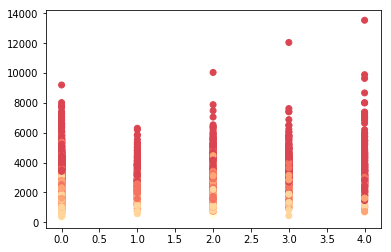

In [7]:
plt.scatter(x=list(data['view']),y=list(data['sqft_living']),color =a)
plt.show()

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
d = min_max_scaler.fit_transform(newdata) #Normalized data matrix
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(d, price, test_size=0.2, random_state=42)

/Users/amy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [9]:
from flask import Flask,jsonify
import json
from flask_cors import CORS
from scipy.spatial import distance

In [10]:
def KNN(data, sqft, zipcode, year, bedroom, bathroom): #input sqft, zipcode, year, bedroom, bathroom to do prediction
    ob = pd.DataFrame(np.matrix([sqft, year, bedroom, bathroom]), columns=['sqft_living','yr_built','bedrooms','bathrooms'])
    df_zipcode = data[['sqft_living','zipcode','yr_built','bedrooms','bathrooms']] #filter by zipcode
    df_zipcode = df_zipcode[df_zipcode['zipcode'] == zipcode][['sqft_living','yr_built','bedrooms','bathrooms']]
    df_zipcode = df_zipcode.append(ob)
    df_norm = min_max_scaler.fit_transform(df_zipcode)
    dist = []
    observation = df_norm[len(df_norm)-1,:]
    for i in range(len(df_norm)-1):
        dist.append(distance.euclidean(df_norm[i,:],observation)) #find the observations with smallest distance
    index = np.argsort(dist)[:10]
    df_10 = df_zipcode.iloc[index,:]
    return df_10 #return index of dataframe

In [11]:
def predict(clf,data,newdata,sqft,zipcode, year, bedroom, bathroom): #data:original data #newdata:dummydata
    temp = KNN(data, sqft, zipcode, year, bedroom, bathroom)
    index = temp.index
    df = newdata[newdata.index.isin(index)]
    min_max_scaler.fit(newdata) #normalize 
    df_norm = min_max_scaler.transform(df)
    top_prediction = clf.predict(df_norm) #do predition
    return np.median(top_prediction) 

In [12]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1) 
clf.fit(X_train,y_train)

/Users/amy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
width = max(list(data['price'])) - min(list(data['price']))
length = 300
seg = 5000
price = []
num = []
a = 75000
b = a + seg
for i in range(length):
    num.append(len(data[data['price'].between(a,b-1)]))
    price.append(a)
    a = a + seg
    b = b + seg

In [14]:
width = max(list(data['sqft_living'])) - min(list(data['sqft_living']))
length = 300
seg = 20
sqft_l = []
numm = []
a = 290
b = a + seg
for i in range(length):
    numm.append(len(data[data['sqft_living'].between(a,b-1)]))
    sqft_l.append(a)
    a = a + seg
    b = b + seg

In [15]:
def sqft_range_sample(data,a,b):
    data_fil = data[(data['sqft_living'] > a) & (data['sqft_living'] < b)]
    return data_fil

In [16]:
def price_range_sample(data,a,b):
    data_fil = data[(data['price'] > a) & (data['price'] < b)]
    return data_fil

In [17]:
app = Flask(__name__)
CORS(app)
@app.route('/project/status=<status>&sqft=<sqft>&zipcode=<zipcode>&year=<year>&bedroom=<bedroom>&bathroom=<bathroom>&mi=<mi>&ma=<ma>&mis=<mis>&mas=<mas>', methods=['GET'])
def server(status,sqft,zipcode,year,bedroom,bathroom,mi,ma,mis,mas): 
    status = int(status)
    sqft = float(sqft)
    zipcode = int(zipcode)
    year = int(year)
    bedroom = float(bedroom)
    bathroom = float(bathroom)
    mi = float(mi)
    ma = float(ma)
    mis = float(mis)
    mas = float(mas)
    if(status == 1): # st = 1 means we want to do a prediction
        price_pred = predict(clf,data,newdata,sqft,zipcode,year,bedroom,bathroom)
        return json.dumps(price_pred)
    if(status == 2): # return sample data
        dict_2 = []
        d = data.sample(100)
        d = d[['sqft_living','zipcode','yr_built','bedrooms','bathrooms','lat','long','price']]
        return d.to_json(orient='split')
    if(status == 3): #return data zipcode vs average price
        zipcode = list(Counter(data.iloc[:,16]).keys())
        count = list(Counter(data.iloc[:,16]).values())
        a_list = []
        for i in range(len(zipcode)):
            temp = data[data['zipcode'] == zipcode[i]]
            s = np.sum(temp['price'])
            average = s / count[i]
            a_list.append({'zipcode':float(zipcode[i]),'average':average})
        return json.dumps(a_list)
    if(status == 4): #return observations with price between mi and ma, with sqft between mis and mas
        d = price_range_sample(data,mi,ma)
        d = sqft_range_sample(d,mis,mas)
        d = d[['sqft_living','zipcode','yr_built','bedrooms','bathrooms','lat','long','price']]
        if(len(d) > 50):
            d = d.sample(50)
        return d.to_json(orient='split')
    if(status == 5): #return most similar
        index = KNN(data, sqft,zipcode,year,bedroom,bathroom).index
        df = data[data.index.isin(index)]
        d = df[['sqft_living','zipcode','yr_built','bedrooms','bathrooms','lat','long','sqft_basement','condition','floors','price']]
        return d.to_json(orient='split')

In [ ]:
if __name__ == '__main__':
    app.run() #The port will be 5000

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
/Users/amy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
127.0.0.1 - - [05/Dec/2018 17:06:37] "GET /project/status=1&sqft=7246&zipcode=98102&year=1951&bedroom=5&bathroom=3&mi=0&ma=0&mis=0&mas=0 HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2018 17:06:38] "GET /project/status=5&sqft=7246&zipcode=98102&year=1951&bedroom=5&bathroom=3&mi=2&ma=2&mis=290&mas=290 HTTP/1.1" 200 -
127.0.0.1 - - [05/Dec/2018 17:06:54] "GET /project/status=5&sqft=7246&zipcode=98102&year=1951&bedroom=5&bathroom=3&mi=2&ma=2&mis=290&mas=290 HTTP/1.1" 200 -
/Users/amy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
127.0.0.1 - -